In [1]:
import tensorflow as tf
from tensorflow import keras as keras
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.image as mpimg
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Lambda, LayerNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, History, EarlyStopping

In [2]:
from sample.functionImplemented import get_model, custom_loss, get_threshold, schedule, custom_scaler, get_opt_action, update_replay_helper, populate_replay_memory, update_replay_memory 
from sample.car import Car
from sample.track import Track

(882, 1174)


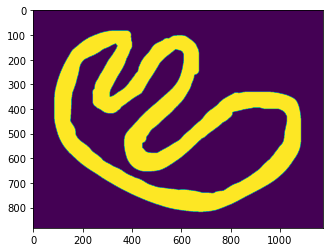

In [3]:
img = mpimg.imread("tracks/track_pic9.jpg")[:,:,0]
track1=(img<50).astype('int')
print(track1.shape)
track_rows, track_cols=track1.shape
pos_pos=np.where(track1==1)
spawning_positions=np.zeros((len(pos_pos[0]), 2))
spawning_positions[:, 0]=pos_pos[0]
spawning_positions[:, 1]=pos_pos[1]
spawning_positions=spawning_positions.astype('int')

track=Track(track1, 5)
l=spawning_positions[np.random.choice(range(len(spawning_positions)), size=(20, ))]

for (i,j) in l:
    track.add_checkpoints(i,j)
track.checkpoints=np.asarray(track.checkpoints)
track.spawn_at=np.asarray(track.spawn_at)
plt.imshow(track1)
plt.show()

In [5]:
throttle_quant=np.linspace(-1,1,9)
steer_quant=np.linspace(-1,1,7)
actions=np.asarray([(throttle, steer) for throttle in throttle_quant for steer in steer_quant]) 
data_scaler=np.asarray([
    100, 100, 100, 100,
    100, 100, 100, 100,
    50, 1, 1
])
usescaler=True
gamma=0.9
trainedModel=tf.keras.models.load_model("TrainedModels/trainedModelspa1.h5", custom_objects={'cl':custom_loss(gamma)})

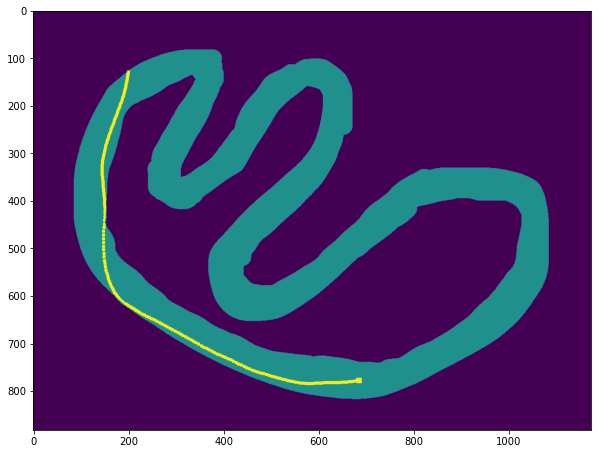

In [29]:
new_car=Car(track, 80, 10.0)
# new_car.sampling_frequency=10.0
throttle_trace=[]
steer_trace=[]
speed_trace=[]

def get_plot(positions, superimposeon_this):
    x, y=positions
    for x_diff in range(-5, 7):
        for y_diff in range(-5, 7):
            if np.sqrt(x_diff**2+y_diff**2)<14:
                superimposeon_this[x+x_diff][y+y_diff]=1
    f=plt.figure(figsize=(10, 20))
    plt.imshow(superimposeon_this+new_car.track.track)
    plt.show()
    return


base_fig=np.zeros((track_rows, track_cols))


for iteration in range(200):
    r, c=new_car.integer_position_
    for x_diff in range(-3, 4):
        for y_diff in range(-3, 4):
            if np.sqrt(x_diff**2+y_diff**2)<4:
                if r+x_diff<new_car.track.track.shape[0] and c+y_diff<new_car.track.track.shape[1]:
                    base_fig[r+x_diff][c+y_diff]=1
                    
                    
    throttle, steer=get_opt_action(new_car, trainedModel, actions, data_scaler, usescaler)
    throttle_trace.append(throttle)
    steer_trace.append(steer)
    speed_trace.append(new_car.speed)
    
    theta=new_car.car_angle
    f1, f2=throttle*np.sin(theta)-steer*np.cos(theta), throttle*np.cos(theta)+steer*np.sin(theta)
#     print(steer, new_car.speed, new_car.car_angle, new_car.current_position)
    new_car.execute_forces(f1, f2, max_magnitudes=20)
#     new_car.speed=20.0
    if new_car.collided_on_last:
        print("boom")
        break
        
get_plot(new_car.integer_position_, base_fig)  

d:\vaibhav_personal\entertainment\new_cargame\updated_cargame\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


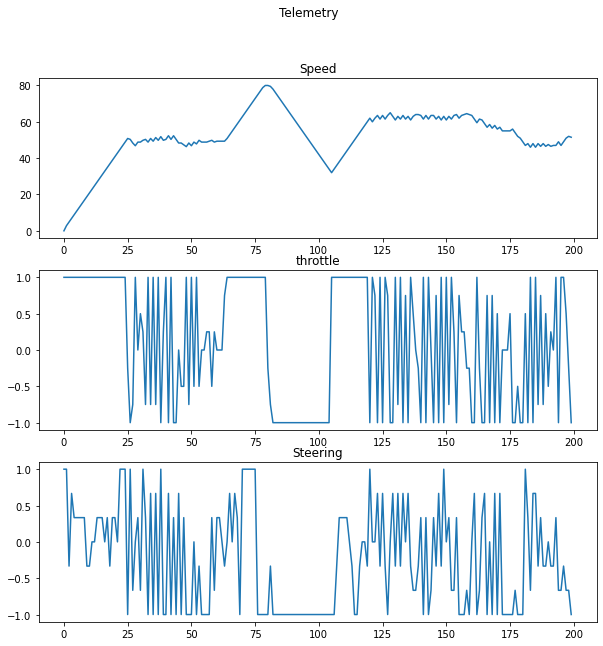

In [31]:
telemetry_plts=plt.figure(figsize=(10, 10))
ax1=telemetry_plts.add_subplot(3, 1, 1)
ax1.plot(speed_trace)
ax2=telemetry_plts.add_subplot(3, 1, 2)
ax2.plot(throttle_trace)
ax3=telemetry_plts.add_subplot(3, 1, 3)
ax3.plot(steer_trace)
ax1.set_title("Speed")
ax2.set_title("throttle")
ax3.set_title("Steering")
telemetry_plts.suptitle("Telemetry")
telemetry_plts.show()

In [ ]:
trainedModel.